Section 1 - A Simplified Decision Tree

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
#Creating the Decision Tree Node Class
class DTNode():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain_ratio=None, value=None, info_gain=None):
        
        #decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain_ratio = info_gain_ratio
        self.info_gain = info_gain

        #leaf node
        self.value = value

In [5]:
class DecisionTreeClassifier:
    def __init__(self, min_samp_split=2, max_depth=2):
        
        self.root = None

        self.min_samp_split = min_samp_split
        self.max_depth = max_depth

    def _build_tree(self, dataset, depth=0):

        #Split the features(X) and the targets(y)
        X, y = dataset[:,:-1], dataset[:,-1]
        num_samp, num_feat = np.shape(X)

        #Continue splitting the tree until requirements are met
        if num_samp>=self.min_samp_split and depth<=self.max_depth:
            best_split = self._find_best_split(dataset, num_samp, num_feat)
            
            # Ensure that info_gain is positive
            if best_split["info_gain"]>0:
                
                #recur left or right
                left_tree = self._build_tree(best_split["data_left"], depth+1)
                right_tree = self._build_tree(best_split["data_right"], depth+1)
                return DTNode(best_split["feature_index"], best_split["threshold"],
                              left_tree, right_tree, best_split["info_gain"])
            
        #Compute the leaf node
        leaf_val = self._calc_leaf_val(y)
        return DTNode(value=leaf_val)
    
    def _find_best_split(self, dataset, num_samp, num_feat):

        best_split = {}
        best_info_gain_ratio = -float("inf")

        #loop over all features
        for feature_index in range(num_feat):
            feat_vals = dataset[:, feature_index]
            unique_thresholds = np.unique(feat_vals)
            #loop over all present features within the data
            for threshold in unique_thresholds:
                #current split
                data_left, data_right = self.split(dataset, feature_index, threshold)
                #ensure that the children nodes are not null
                if len(data_left)>0 and len(data_right)>0:
                    y, left_y, right_y = dataset[:, -1], data_left[:,-1], data_right[:, -1]
                    #calculate your information gain
                    current_info_gain_ratio = self._calc_info_gain_ratio(y, left_y, right_y)
                    #update your best split if current_info_gain_ratio>best_info_gain_ratio
                    if current_info_gain_ratio>best_info_gain_ratio:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["data_left"] = data_left
                        best_split["data_right"] = data_right
                        best_split["info_gain"] = current_info_gain_ratio
                        best_info_gain_ratio = current_info_gain_ratio

        return best_split

    def split(self, dataset, feature_index, threshold):

        data_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        data_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return data_left, data_right

    def _information_gain(self, parent, l_child, r_child, mode="entropy"):
        l_weight = len(l_child)/len(parent)
        r_weight = len(r_child)/len(parent)
        if mode == "gini":
            gain = self._gini_index(parent)-(l_weight*self._gini_index(l_child)+r_weight*self._gini_index(r_child))
        else:
            gain = self._entropy(parent)-(l_weight*self._entropy(l_child)+r_weight*self._entropy(r_child))
        return gain

    def _entropy(self, y):

        cls_lbls = np.unique(y)
        entropy = 0
        for cls in cls_lbls:
            p_cls = len(y[y == cls])/len(y)
            entropy += -p_cls*np.log2(p_cls)
        return entropy
    
    def _gini_index(self, y):

        cls_lbls = np.unique(y)
        gini = 0
        for cls in cls_lbls:
            p_cls = len(y[y == cls])/len(y)
            gini += p_cls**2
        return 1-gini
    
    def _calc_leaf_val(self, y):
        
        y = list(y)
        return max(y, key=y.count)
    
    def _print_tree(self, tree = None, indent = " "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain_ratio)
            print("%sleft:" % (indent), end = "")
            self._print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end = "")
            self._print_tree(tree.right, indent + indent)

    def fit(self, X, y):

        dataset = np.concatenate((X, y), axis=1)
        self.root = self._build_tree(dataset)

    def prediction(self, X):

        prediction = [self.predict(x, self.root) for x in X]
        return prediction
    
    def predict(self, x, tree):
        
        if tree.value != None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.predict(x, tree.left)
        else:
            return self.predict(x, tree.right)
    
    #Defining a new function needed for Section 2 - Question 3

    def _calc_info_gain_ratio(self, parent, l_child, r_child):
        # Calculate the information gain ratio
        gain = self._information_gain(parent, l_child, r_child, mode="entropy")
        # split_entropy = (len(l_child) / len(parent)) * self._entropy(l_child) + (len(r_child) / len(parent)) * self._entropy(r_child)
        split_entropy = self._entropy(l_child) + self._entropy(r_child)
        if split_entropy == 0:
            return gain  # If the split entropy is zero, return information gain
        info_gain_ratio = gain / split_entropy
        return info_gain_ratio
    
    def count_nodes(self):
        return self._count_nodes(self.root)

    def _count_nodes(self, node):
        if node is None:
            return 0
        if node.value is not None:
            return 1
        return 1 + self._count_nodes(node.left) + self._count_nodes(node.right)

In [45]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris.csv", skiprows=1, header=None, names=col_names)

In [46]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [47]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=3)
clf.fit(X_train,Y_train)
clf._print_tree()

X_2 <= 1.9 ? 0.9265117591279095
 left:Setosa
 right:X_3 <= 1.5 ? 1.6846951971325457
  left:X_2 <= 4.9 ? 0.17556502585750278
    left:Versicolor
    right:Virginica
  right:X_2 <= 5.0 ? 0.15148396351473561
    left:X_1 <= 2.8 ? 0.5084605302271179
        left:Virginica
        right:Versicolor
    right:Virginica


In [49]:
y_pred = clf.prediction(X_test) 
accuracy_score(Y_test, y_pred)

0.9333333333333333

In [147]:
# Create your training and testing set here
X = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
y = np.array([[0,0], [0,1], [0,0], [0,1], [0,0]])  # Two classes: 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=27)

In [148]:
classifier = DecisionTreeClassifier(min_samp_split=3, max_depth=3)
classifier.fit(X_train,y_train)
classifier._print_tree()

X_0 <= 1 ? 0.3389736868180786
 left:0
 right:X_0 <= 4 ? 0.9182958340544896
  left:1
  right:0


Section 2 - Question 2

In [5]:
import matplotlib.pyplot as plt

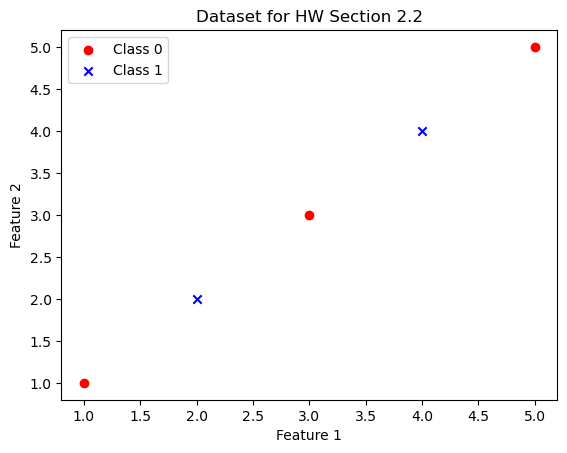

In [150]:
# Generate a small dataset
X = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
y = np.array([0, 1, 0, 1, 0])  # Two classes: 0 and 1

# Plot the dataset
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', marker='o', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', marker='x', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Dataset for HW Section 2.2')
plt.show()


Section 2 - Question 3

In [6]:
from collections import Counter
from math import log2

In [136]:
# Text file data converted to float data type
Druns = np.loadtxt("Druns.txt", dtype=float)
data = pd.DataFrame(Druns, columns=['X_0', 'X_1', 'Target'])
print(data)

    X_0  X_1  Target
0   0.1 -2.0     0.0
1   0.0 -1.0     1.0
2   0.0  0.0     0.0
3   0.0  1.0     0.0
4   0.0  2.0     0.0
5   0.0  3.0     0.0
6   0.0  4.0     0.0
7   0.0  5.0     0.0
8   0.0  6.0     1.0
9   0.0  7.0     0.0
10  0.0  8.0     1.0


In [9]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)

In [10]:
# Create an instance of the DecisionTreeClassifier
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=2)

# Fit the classifier to your training data
clf.fit(X, y)

# Retrieve the root node of the constructed decision tree
root_node = clf.root

# Function to print candidate cuts and their information gain ratios
def print_candidate_cuts(node):
    if node.feature_index is not None:
        # Node is a decision node
        print(f"Feature {node.feature_index}: Threshold {node.threshold}")
        print(f"Information Gain Ratio: {node.info_gain_ratio:.4f}")
        if node.info_gain_ratio == 0:
            print(f"Mutual Information (Information Gain): {node.info_gain:.4f}")
        print("---")
        # Recursively print left and right branches
        print_candidate_cuts(node.left)
        print_candidate_cuts(node.right)

# Print all candidate cuts and their information gain ratios
print("Candidate Cuts and Information Gain Ratios:")
print_candidate_cuts(root_node)

Candidate Cuts and Information Gain Ratios:
Feature 1: Threshold 7.0
Information Gain Ratio: 0.2619
---
Feature 1: Threshold -1.0
Information Gain Ratio: 0.0564
---
Feature 0: Threshold 0.0
Information Gain Ratio: 1.0000
---
Feature 1: Threshold 5.0
Information Gain Ratio: 0.2936
---


Section 2 - Question 4

In [137]:
# Text file data converted to integer data type
D3leaves = np.loadtxt("D3leaves.txt", dtype=int)
data = pd.DataFrame(D3leaves, columns=['X_0', 'X_1', 'Target'])
print(data)

   X_0  X_1  Target
0   10    1       1
1   10    2       1
2   10    3       1
3    1    1       0
4    1    3       1


In [22]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)

In [23]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=3)
clf.fit(X, y)
clf._print_tree()

X_0 <= 1 ? 0.3219280948873623
 left:X_1 <= 1 ? 1.0
  left:0
  right:1
 right:1


Section 2 - Question 5 - D1 Dataset

In [138]:
# Text file data converted to float data type
D1 = np.loadtxt("D1.txt", dtype=float)
data_D1 = pd.DataFrame(D1, columns=['X_0', 'X_1', 'Target'])
print(data_D1)

          X_0       X_1  Target
0    0.264185  0.178456     0.0
1    0.409499  0.213456     1.0
2    0.926224  0.540329     1.0
3    0.573685  0.282145     1.0
4    0.953159  0.608121     1.0
..        ...       ...     ...
995  0.211320  0.737143     1.0
996  0.625005  0.233578     1.0
997  0.285166  0.956678     1.0
998  0.751571  0.514041     1.0
999  0.142654  0.226182     1.0

[1000 rows x 3 columns]


In [133]:
X_1 = data_D1.iloc[:, :-1].values
y_1 = data_D1.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=.2, random_state=27)

In [134]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=4)
clf.fit(X_train,y_train)
clf._print_tree()

X_1 <= 0.199558 ? 40.43122398368505
 left:0.0
 right:X_1 <= 0.443057 ? 0.057578260053394045
  left:X_1 <= 0.268859 ? 0.07142146258780589
    left:X_1 <= 0.199725 ? 0.12741851179235877
        left:0.0
        right:1.0
    right:1.0
  right:1.0


Section 2 - Question 5 - Dataset D2

In [139]:
# Text file data converted to float data type
D2 = np.loadtxt("D2.txt", dtype=float)
data_D2 = pd.DataFrame(D2, columns=['X_0', 'X_1', 'Target'])
print(data_D2)

          X_0       X_1  Target
0    0.315561  0.956006     1.0
1    0.344972  0.693422     1.0
2    0.398419  0.974354     1.0
3    0.347109  0.566740     0.0
4    0.985903  0.564388     1.0
..        ...       ...     ...
995  0.418671  0.044160     0.0
996  0.794456  0.142425     0.0
997  0.384576  0.609262     0.0
998  0.843186  0.848278     1.0
999  0.691812  0.751075     1.0

[1000 rows x 3 columns]


In [79]:
X_2 = data_D2.iloc[:, :-1].values
y_2 = data_D2.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=.2, random_state=27)

In [80]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=4)
clf.fit(X_train,y_train)
clf._print_tree()

X_0 <= 0.532168 ? 0.14796308667908534
 left:X_1 <= 0.532684 ? 0.34798879043344644
  left:0.0
  right:X_1 <= 0.917219 ? 0.20336117490014413
    left:X_0 <= 0.417579 ? 0.3264313021382538
        left:X_0 <= 0.108693 ? 0.18874347712539954
                left:0.0
                right:0.0
        right:1.0
    right:1.0
 right:X_1 <= 0.421367 ? 0.3656264501302198
  left:X_0 <= 0.776658 ? 0.19858671424292895
    left:X_1 <= 0.267904 ? 0.2689838499447799
        left:0.0
        right:X_0 <= 0.635403 ? 0.5226035612534985
                left:0.0
                right:1.0
    right:X_1 <= 0.168115 ? 0.4262082636198876
        left:X_0 <= 0.904329 ? 0.5893283056767006
                left:0.0
                right:1.0
        right:1.0
  right:1.0


Section 2 - Question 6

In [95]:
# Create the functions that will create the decision boundry needed for part 2 of Question 6
from typing import Callable

def draw_decision_boundary(model_function:Callable, grid_abs_bound:float=1.0, _grid_abs_bound:float=-1.0, savefile:str=None):
    # """`model_function` should be your model's formula for evaluating your decision tree, returning either `0` or `1`.
    # \n`grid_abs_bound` represents the generated grids absolute value over the x-axis, default value generates 50 x 50 grid.
    # \nUse `grid_abs_bound = 1.0` for question 6 and `grid_abs_bound = 1.5` for question 7.
    # \nSet `savefile = 'plot-save-name.png'` to save the resulting plot, adjust colors and scale as needed."""
    
    colors=['#91678f','#afd6d2'] # hex color for [y=0, y=1]
    
    xval = np.linspace(grid_abs_bound,_grid_abs_bound,50).tolist() # grid generation
    xdata = []
    for i in range(len(xval)):
        for j in range(len(xval)):
            xdata.append([xval[i],xval[j]])

    df = pd.DataFrame(data=xdata,columns=['x_0','x_1']) # creates a dataframe to standardize labels
    df['y'] = df.apply(model_function,axis=1) # applies model from model_function arg
    d_columns = df.columns.to_list() # grabs column headers
    y_label = d_columns[-1] # uses last header as label
    d_xfeature = d_columns[0] # uses first header as x_1 feature
    d_yfeature = d_columns[1] # uses second header as x_1 feature
    df = df.sort_values(by=y_label) # sorts by label to ensure correct ordering in plotting loop

    d_xlabel = f"feature  $\mathit{{{d_xfeature}}}$" # label for x-axis
    dy_ylabel = f"feature  $\mathit{{{d_yfeature}}}$" # label for y-axis
    plt.xlabel(d_xlabel, fontsize=10) # set x-axis label
    plt.ylabel(dy_ylabel, fontsize=10) # set y-axis label
    legend_labels = [] # create container for legend labels to ensure correct ordering

    for i,label in enumerate(df[y_label].unique().tolist()): # loop through placeholder dataframe
        df_set = df[df[y_label]==label] # sort according to label
        set_x = df_set[d_xfeature] # grab x_1 feature set
        set_y = df_set[d_yfeature] # grab x_2 feature set
        plt.scatter(set_x,set_y,c=colors[i],marker='s', s=40) # marker='s' for square, s=40 for size of squares large enough
        legend_labels.append(f"""{y_label} = {label}""") # apply labels for legend in the same order as sorted dataframe

    plt.title("Model Decision Boundary", fontsize=12) # set plot title
    ax = plt.gca() # grab to set background color of plot
    ax.set_facecolor('#2b2d2e') # set aforementioned background color in hex color
    plt.legend(legend_labels) # create legend with sorted labels

    if savefile is not None: # save your plot as .png file
        plt.savefig(savefile)
    plt.show() # show plot with decision bounds

Section 2 - Question 6 - D1 Dataset

In [151]:
x = data_D1.iloc[:, :1].values
y = data_D1.iloc[:, 1].values.reshape(-1,1)
t = data_D1.iloc[:, -1].values.reshape(-1,1)

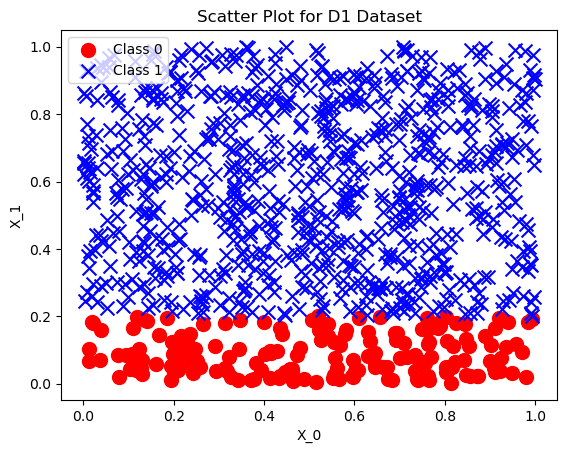

In [152]:
# Separate data points based on classification
x_class_0 = [x[i] for i in range(len(t)) if t[i] == 0]
y_class_0 = [y[i] for i in range(len(t)) if t[i] == 0]

x_class_1 = [x[i] for i in range(len(t)) if t[i] == 1]
y_class_1 = [y[i] for i in range(len(t)) if t[i] == 1]

# Create a scatterplot for each class
plt.scatter(x_class_0, y_class_0, label='Class 0', color='red', marker='o', s=100)
plt.scatter(x_class_1, y_class_1, label='Class 1', color='blue', marker='x', s=100)

# Add labels and title
plt.xlabel('X_0')
plt.ylabel('X_1')
plt.title('Scatter Plot for D1 Dataset')

# Add a legend
plt.legend()

# Display the plot
plt.show()

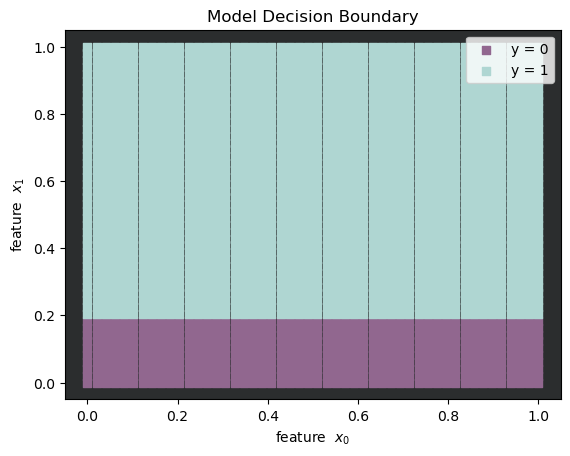

In [97]:
#Decison Boundry Visual for D1 dataset
def model_D1(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_1 <= 0.199558:
        return 0
    if x_1 >= 0.199558:
        if x_1 <= 0.443057:
            if x_1 <= 0.268859:
                if x_1 <= 0.199725:
                    return 0
                return 1
            return 1
        return 1
    return 1

draw_decision_boundary(model_function=model_D1, grid_abs_bound=1, _grid_abs_bound=0) # generate decision boundary plot

Section 2 - Question 6 - D2 Dataset

In [143]:
x = data_D2.iloc[:, :1].values
y = data_D2.iloc[:, 1].values.reshape(-1,1)
t = data_D2.iloc[:, -1].values.reshape(-1,1)

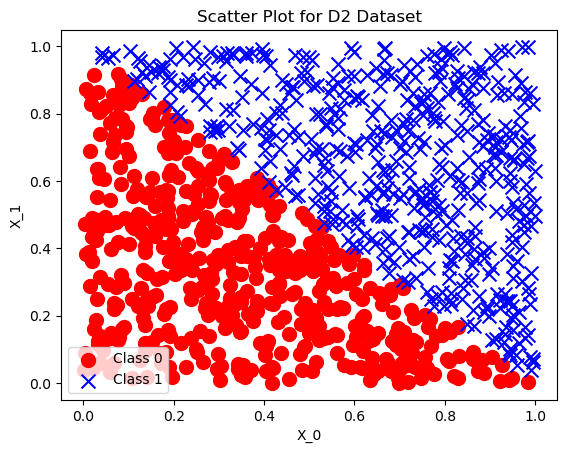

In [144]:
# Separate data points based on classification
x_class_0 = [x[i] for i in range(len(t)) if t[i] == 0]
y_class_0 = [y[i] for i in range(len(t)) if t[i] == 0]

x_class_1 = [x[i] for i in range(len(t)) if t[i] == 1]
y_class_1 = [y[i] for i in range(len(t)) if t[i] == 1]

# Create a scatterplot for each class
plt.scatter(x_class_0, y_class_0, label='Class 0', color='red', marker='o', s=100)
plt.scatter(x_class_1, y_class_1, label='Class 1', color='blue', marker='x', s=100)

# Add labels and title
plt.xlabel('X_0')
plt.ylabel('X_1')
plt.title('Scatter Plot for D2 Dataset')

# Add a legend
plt.legend()

# Display the plot
plt.show()

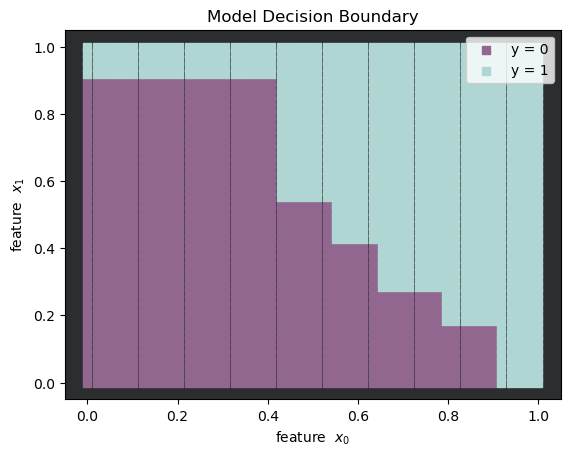

In [96]:
#Decison Boundry Visual for D2 dataset
def model_D2(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_0 <= 0.532168:
        if x_1 <= 0.532684:
            return 0
        if x_1 >= 0.532684:
            if x_1 <= 0.917219:
                if x_0 <= 0.417579:
                    if x_0 <= 0.108693:
                        return 0
                    return 0
                return 1
            return 1
    if x_0 >= 0.532168:
        if x_1 <= 0.421367:
            if x_0 <= 0.776658:
                if x_1 <= 0.267904:
                    return 0
                if x_1 >= 0.267904:
                    if x_0 <= 0.635403:
                        return 0
                    return 1
                return 1
            if x_0 >= 0.776658:
                if x_1 <= 0.168115:
                    if x_0 <= 0.904329:
                        return 0
                    return 1
                return 1
            return 1
        return 1

draw_decision_boundary(model_function=model_D2, grid_abs_bound=1, _grid_abs_bound=0) # generate decision boundary plot

Section 2 - Question 7

In [9]:
# Text file data converted to float data type
DBig = np.loadtxt("DBig.txt", dtype=float)
data_DBig = pd.DataFrame(DBig, columns=['X_0', 'X_1', 'Target'])
print(data_DBig)

           X_0       X_1  Target
0    -1.499372  0.976384     1.0
1    -1.499224 -0.517983     1.0
2    -1.498880 -1.271624     1.0
3    -1.498383  1.456647     1.0
4    -1.498293 -1.290862     1.0
...        ...       ...     ...
9995  1.498964  0.036682     1.0
9996  1.499012  1.444314     1.0
9997  1.499284  0.447541     1.0
9998  1.499313  1.092598     1.0
9999  1.499767  0.661564     1.0

[10000 rows x 3 columns]


In [108]:
#Creating a scatter plot to see how well the decison boundries match to the actual data
x = data_DBig.iloc[:, :1].values
y = data_DBig.iloc[:, 1].values.reshape(-1,1)
t = data_DBig.iloc[:, -1].values.reshape(-1,1)

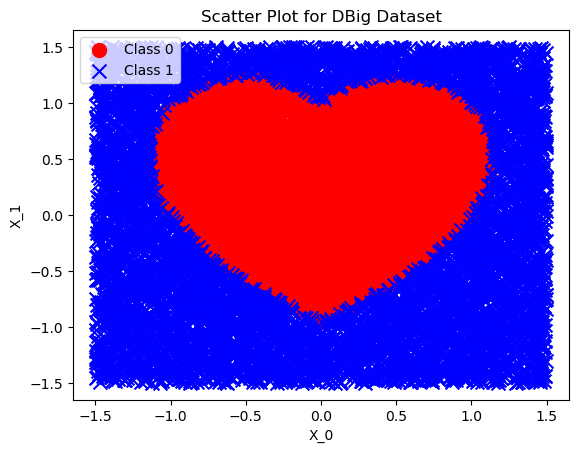

In [109]:
# Separate data points based on classification
x_class_0 = [x[i] for i in range(len(t)) if t[i] == 0]
y_class_0 = [y[i] for i in range(len(t)) if t[i] == 0]

x_class_1 = [x[i] for i in range(len(t)) if t[i] == 1]
y_class_1 = [y[i] for i in range(len(t)) if t[i] == 1]

# Create a scatterplot for each class
plt.scatter(x_class_0, y_class_0, label='Class 0', color='red', marker='o', s=100)
plt.scatter(x_class_1, y_class_1, label='Class 1', color='blue', marker='x', s=100)

# Add labels and title
plt.xlabel('X_0')
plt.ylabel('X_1')
plt.title('Scatter Plot for DBig Dataset')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [7]:
# Set the number of samples you want in the training set
train_size = 8192

# Generate a random permutation of indices
X_Big = data_DBig.iloc[:, :-1].values
indices_X = np.random.default_rng(seed=27).permutation(len(X_Big))
y_Big = data_DBig.iloc[:, -1].values.reshape(-1,1)

# Split the indices into training and test sets
train_indices = indices_X[:train_size]
test_indices = indices_X[train_size:]

# Use the indices to split the dataset
X_train = X_Big[train_indices]
X_test = X_Big[test_indices]
y_train = y_Big[train_indices]
y_test = y_Big[test_indices]

# Check the shapes of the resulting sets
print("Training Feature set shape:", X_train.shape)
print("Training Target set shape:", y_train.shape)
print("Testing Feature shape:", X_test.shape)
print("Testing Target shape:", y_test.shape)

Training Feature set shape: (8192, 2)
Training Target set shape: (8192, 1)
Testing Feature shape: (1808, 2)
Testing Target shape: (1808, 1)


In [82]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=6)
clf.fit(X_train,y_train)
num_nodes = clf.count_nodes()
clf._print_tree()
print("Number of nodes (n):", num_nodes)

X_1 <= -0.92622 ? 0.16421452254640959
 left:X_1 <= -1.098875 ? 0.050458257176636316
  left:1.0
  right:X_1 <= -0.977344 ? 0.06028317929759724
    left:1.0
    right:X_0 <= 0.005267 ? 0.06718622104277962
        left:X_0 <= -0.059687 ? 0.10559103637519526
                left:1.0
                right:0.0
        right:1.0
 right:X_0 <= 1.135738 ? 0.13672189852852057
  left:X_0 <= -1.138472 ? 0.19870440454373078
    left:1.0
    right:X_1 <= 1.231492 ? 0.25451329603377665
        left:X_1 <= -0.511474 ? 0.11993570320085506
                left:X_0 <= 0.56249 ? 0.16627123337587388
                                left:X_0 <= -0.569039 ? 0.3537452893335597
                                                                left:1.0
                                                                right:0.0
                                right:1.0
                right:X_0 <= 0.881889 ? 0.046214642325313984
                                left:X_0 <= -0.775048 ? 0.0747565922145647
              

In [83]:
y_pred = clf.prediction(X_test) 
err_8192 = 1-accuracy_score(y_test, y_pred)
print(err_8192)

0.07853982300884954


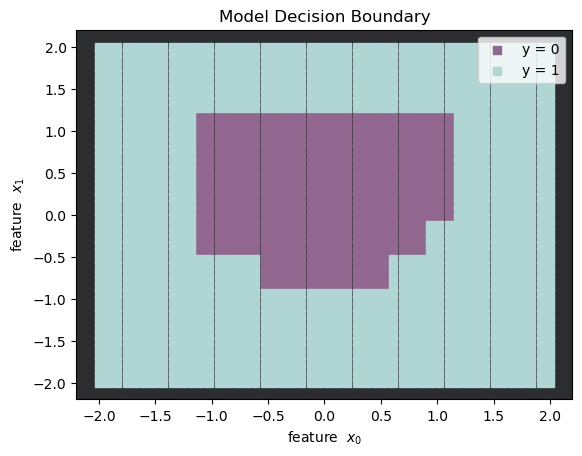

In [105]:
#Decison Boundry Visual for D_8192 dataset
def model_D_8192(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_1 <= -0.92622:
        if x_1 <= -1.098875:
            return 1
        if x_1 >= -1.098875:
            if x_1 <= -0.977344:
                return 1
            if x_1 >= -0.977344:
                if x_0 <= 0.005267:
                    if x_0 <= -0.059687:
                        return 1
                    return 1
                return 1
            return 1
        return 1
    if x_1 >= -0.92622:
        if x_0 <= 1.135738:
            if x_0 <= -1.138472:
                return 1
            if x_0 >= -1.138472:
                if x_1 <= 1.231492:
                    if x_1 <= -0.511474:
                        if x_0 <= 0.56249:
                            if x_0 <= -0.569039:
                                return 1
                            return 0 
                        return 1
                    if x_1 >= -0.511474:
                        if x_0 <= 0.881889:
                            if x_0 <= -0.775048:
                                return 0
                            return 0
                        if x_0 >= 0.881889:
                            if x_1 <= -0.120108:
                                return 1
                            return 0
                        return 1
                    return 1
                return 1
            return 1
        return 1
    return 1

draw_decision_boundary(model_function=model_D_8192, grid_abs_bound=2, _grid_abs_bound=-2) # generate decision boundary plot

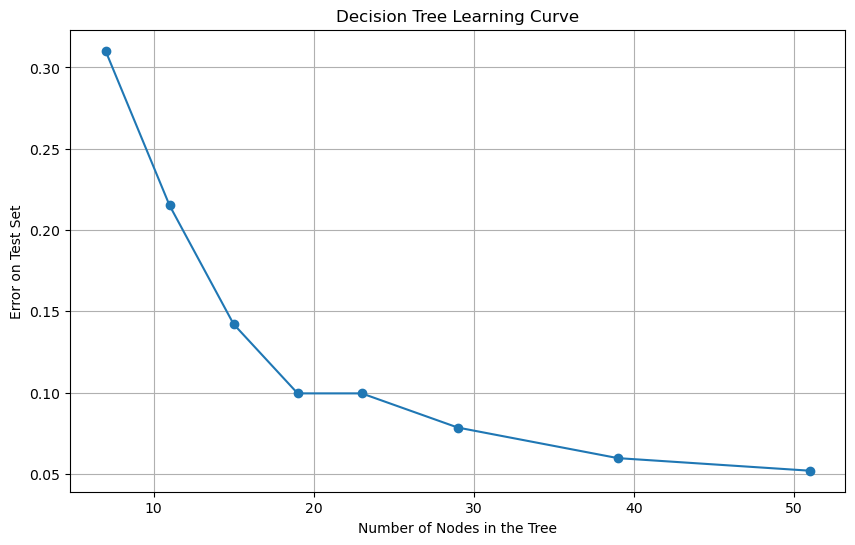

In [84]:
# Create an array of max_depth values to test
max_depths = np.arange(1, 9)  # Adjust the range as needed

# Initialize lists to store results
num_nodes_list = []
err_list = []

# Loop over different max_depth values
for max_depth in max_depths:
    # Create and fit the decision tree classifier
    clf = DecisionTreeClassifier(min_samp_split=2, max_depth=max_depth)
    clf.fit(X_train, y_train)

    # Count the number of nodes in the tree
    num_nodes = clf.count_nodes()
    num_nodes_list.append(num_nodes)

    # Make predictions on the validation set
    y_pred = clf.prediction(X_test)

    # Calculate accuracy
    err_8192 = 1-accuracy_score(y_test, y_pred)
    err_list.append(err_8192)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, err_list, marker='o', linestyle='-')
plt.title('Decision Tree Learning Curve')
plt.xlabel('Number of Nodes in the Tree')
plt.ylabel('Error on Test Set')
plt.grid(True)
plt.show()

In [12]:
train_size = 2048

indices_X = np.random.default_rng(seed=27).permutation(len(X_train))

train_indices = indices_X[:train_size]

X_train_2048 = X_train[train_indices]
y_train_2048 = y_train[train_indices]

print("Training Feature set shape:", X_train_2048.shape)
print("Training Target set shape:", y_train_2048.shape)

Training Feature set shape: (2048, 2)
Training Target set shape: (2048, 1)


In [13]:
train_size = 512

indices_X = np.random.default_rng(seed=27).permutation(len(X_train_2048))

train_indices = indices_X[:train_size]

X_train_512 = X_train_2048[train_indices]
y_train_512 = y_train_2048[train_indices]

print("Training Feature set shape:", X_train_512.shape)
print("Training Target set shape:", y_train_512.shape)

Training Feature set shape: (512, 2)
Training Target set shape: (512, 1)


In [14]:
train_size = 128

indices_X = np.random.default_rng(seed=27).permutation(len(X_train_512))

train_indices = indices_X[:train_size]

X_train_128 = X_train_512[train_indices]
y_train_128 = y_train_512[train_indices]

print("Training Feature set shape:", X_train_128.shape)
print("Training Target set shape:", y_train_128.shape)

Training Feature set shape: (128, 2)
Training Target set shape: (128, 1)


In [15]:
train_size = 32

indices_X = np.random.default_rng(seed=27).permutation(len(X_train_128))

train_indices = indices_X[:train_size]

X_train_32 = X_train_128[train_indices]
y_train_32 = y_train_128[train_indices]

print("Training Feature set shape:", X_train_32.shape)
print("Training Target set shape:", y_train_32.shape)

Training Feature set shape: (32, 2)
Training Target set shape: (32, 1)


Section 2 - Question 7 - Part 3

In [81]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=4)
clf.fit(X_train_2048,y_train_2048)
num_nodes = clf.count_nodes()
clf._print_tree()
print("Number of nodes (n):", num_nodes)

X_1 <= -0.92622 ? 0.17092029950063192
 left:1.0
 right:X_1 <= 1.23018 ? 0.14770248341383516
  left:X_0 <= 1.132337 ? 0.17700820164426864
    left:X_0 <= -1.132926 ? 0.2706193279349405
        left:1.0
        right:X_1 <= -0.203209 ? 0.10935987247169741
                left:1.0
                right:0.0
    right:1.0
  right:1.0
Number of nodes (n): 11


In [56]:
y_pred = clf.prediction(X_test) 
err_2048 = 1-accuracy_score(y_test, y_pred)
print(err_2048)

0.11559734513274333


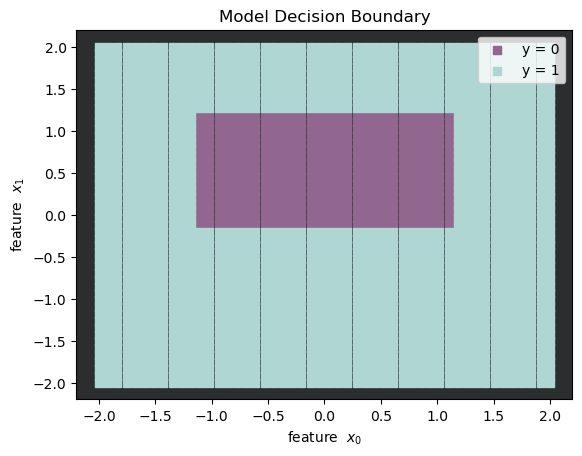

In [104]:
#Decison Boundry Visual for D_2048 dataset
def model_D_2048(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_1 <= -0.92622:
        return 1
    if x_1 >= -0.92622:
        if x_1 <= 1.23018:
            if x_0 <= 1.132337:
                if x_0 <= -1.132926:
                    return 1
                if x_0 >= -1.132926:
                    if x_1 <= -0.203209:
                        return 1
                    return 0
                return 1
            return 1
        return 1
    return 1

draw_decision_boundary(model_function=model_D_2048, grid_abs_bound=2, _grid_abs_bound=-2) # generate decision boundary plot

In [71]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=4)
clf.fit(X_train_512,y_train_512)
num_nodes = clf.count_nodes()
clf._print_tree()
print("Number of nodes (n):", num_nodes)

X_1 <= -0.878247 ? 0.16761760065684683
 left:1.0
 right:X_0 <= 1.124858 ? 0.13535813263250374
  left:X_0 <= -1.095433 ? 0.18971803543361002
    left:1.0
    right:X_1 <= 1.23018 ? 0.22793243468882177
        left:X_1 <= -0.143197 ? 0.1392262333331327
                left:1.0
                right:0.0
        right:1.0
  right:1.0
Number of nodes (n): 11


In [58]:
y_pred = clf.prediction(X_test) 
err_512 = 1-accuracy_score(y_test, y_pred)
print(err_512)

0.12223451327433632


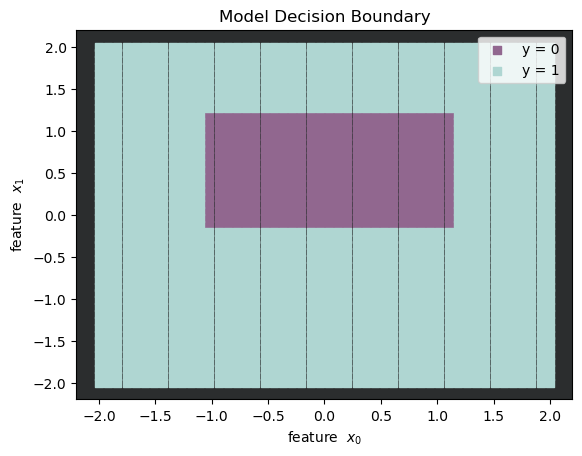

In [103]:
#Decison Boundry Visual for D_512 dataset
def model_D_512(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_1 <= -0.878247:
        return 1
    if x_1 >= -0.878247:
        if x_0 <= 1.124858:
            if x_0 <= -1.095433:
                return 1
            if x_0 >= -1.095433:
                if x_1 <= 1.23018:
                    if x_1 <= -0.143197:
                        return 1
                    return 0
                return 1
            return 1
        return 1
    return 1

draw_decision_boundary(model_function=model_D_512, grid_abs_bound=2, _grid_abs_bound=-2) # generate decision boundary plot

In [70]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=4)
clf.fit(X_train_128,y_train_128)
num_nodes = clf.count_nodes()
clf._print_tree()
print("Number of nodes (n):", num_nodes)

X_1 <= -0.878588 ? 0.18395169875006556
 left:1.0
 right:X_0 <= -1.074275 ? 0.14643232110108875
  left:1.0
  right:X_0 <= 1.118624 ? 0.1675685035592836
    left:X_1 <= 1.11818 ? 0.23826920415444264
        left:X_1 <= 0.064993 ? 0.2906842074517853
                left:0.0
                right:0.0
        right:X_0 <= -0.532228 ? 0.21470175090922847
                left:1.0
                right:1.0
    right:1.0
Number of nodes (n): 13


In [60]:
y_pred = clf.prediction(X_test) 
err_128 = 1-accuracy_score(y_test, y_pred)
print(err_128)

0.12389380530973448


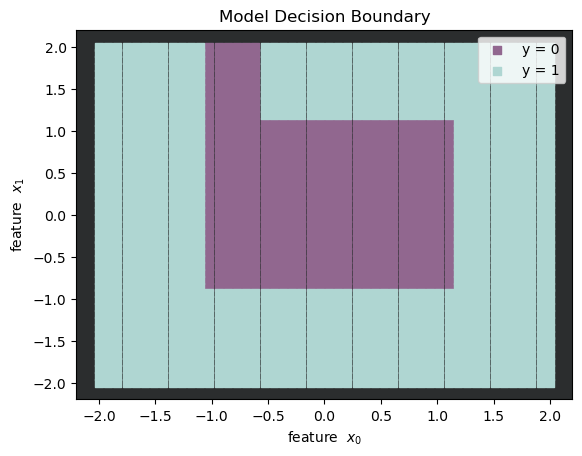

In [101]:
#Decison Boundry Visual for D_128 dataset
def model_D_128(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_1 <= -0.878588:
        return 1
    if x_1 >= -0.878588:
        if x_0 <= -1.074275:
            return 1
        if x_0 >= -1.074275:
            if x_0 <= 1.118624:
                if x_1 <= 1.11818:
                    if x_1 <= 0.064993:
                        return 0
                    return 0
                if x_0 <= -0.532228:
                    return 0
                return 1
            return 1
        return 1
    return 1

draw_decision_boundary(model_function=model_D_128, grid_abs_bound=2, _grid_abs_bound=-2) # generate decision boundary plot

In [16]:
clf = DecisionTreeClassifier(min_samp_split=2, max_depth=4)
clf.fit(X_train_32,y_train_32)
num_nodes = clf.count_nodes()
clf._print_tree()
print("Number of nodes (n):", num_nodes)

X_1 <= -0.895134 ? 0.1689015778634385
 left:1.0
 right:X_0 <= -0.883897 ? 0.14148346247817928
  left:1.0
  right:X_0 <= 1.007646 ? 0.23838590985339583
    left:X_1 <= 1.183769 ? 0.3968159441030005
        left:X_1 <= -0.686107 ? 0.143688098098908
                left:1.0
                right:0.0
        right:1.0
    right:1.0
Number of nodes (n): 11


In [67]:
y_pred = clf.prediction(X_test) 
err_32 = 1-accuracy_score(y_test, y_pred)
print("Err_32:", err_32)

Err_32: 0.08241150442477874


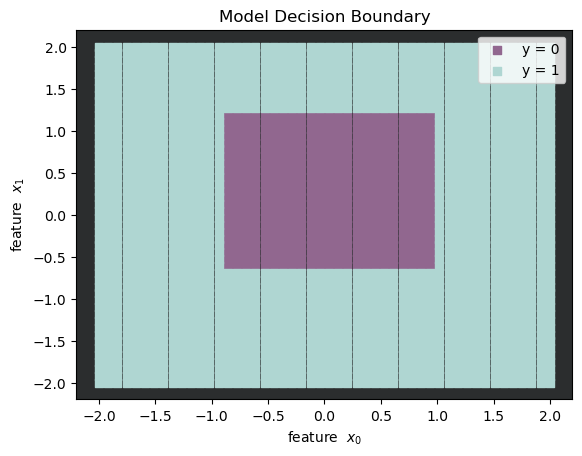

In [102]:
#Decison Boundry Visual for D_32 dataset
def model_D_32(row):
    x_0, x_1 = row.x_0, row.x_1 # grabs standardized labels from pandas.apply function input and renames to more familiar variables
    if x_1 <= -0.895134:
        return 1
    if x_1 >= -0.895134:
        if x_0 <= -0.883897:
            return 1
        if x_0 >= -0.883897:
            if x_0 <= 1.007646:
                if x_1 <= 1.183769:
                    if x_1 <= -0.686107:
                        return 1
                    return 0
                return 1
            return 1
        return 1
    return 1

draw_decision_boundary(model_function=model_D_32, grid_abs_bound=2, _grid_abs_bound=-2) # generate decision boundary plot

Section 3 - sklearn

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [58]:
def _learning_curve(X_train=X_train, y_train=y_train):
    # Create an array of max_depth values to test
    max_depths = np.arange(1, 21)  # Adjust the range as needed

    # Initialize lists to store results
    num_nodes_list = []
    err_list = []

    # Loop over different max_depth values
    for max_depth in max_depths:
        # Create and fit the decision tree classifier
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=27)
        clf.fit(X_train, y_train)

        # Count the number of nodes in the tree
        num_nodes = clf.tree_.node_count
        num_nodes_list.append(num_nodes)

        # Make predictions on the validation set
        y_pred = clf.predict(X_test)

        # Calculate accuracy
        err = 1-accuracy_score(y_test, y_pred)
        err_list.append(err)

In [50]:
#Decision Tree for D_8192
X_train, X_test, y_train, y_test = train_test_split(X_Big, y_Big, test_size=0.1808, random_state=27)

clf = DecisionTreeClassifier(random_state=27)
clf.fit(X_train, y_train)

num_nodes = clf.tree_.node_count
print(f"Number of nodes: {num_nodes}")

Number of nodes: 263


In [51]:
y_pred = clf.predict(X_test)

err_8192 = 1-accuracy_score(y_test, y_pred)
print("Error:", err_8192)

Error: 0.012168141592920345


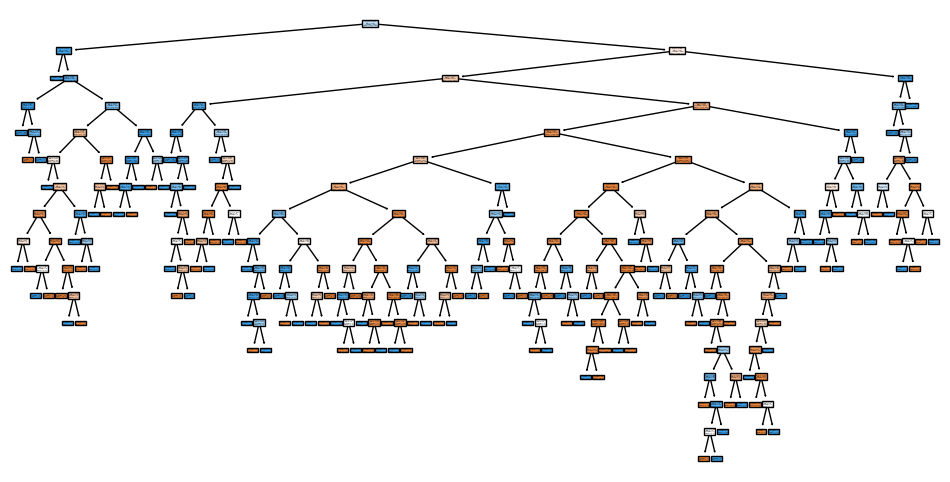

In [52]:
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, filled=True, feature_names=None, class_names=None)
plt.show()

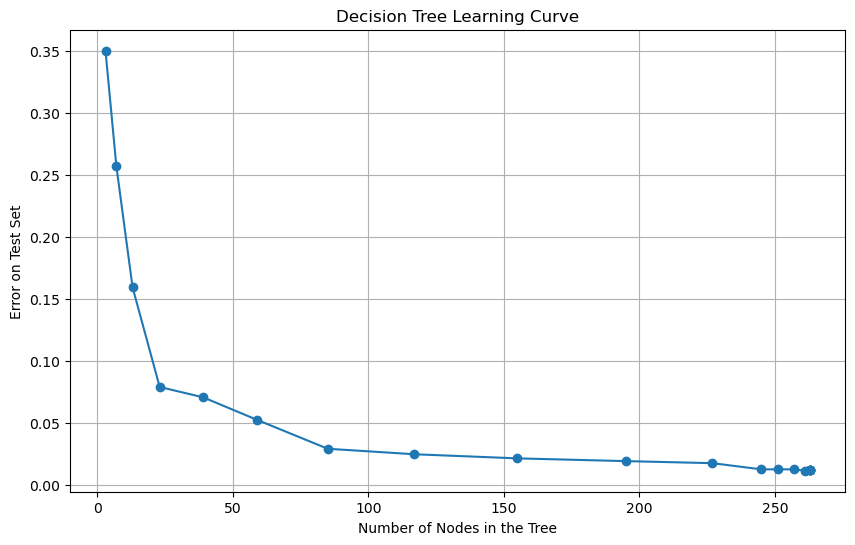

In [60]:
_learning_curve(X_train=X_train, y_train=y_train)
plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, err_list, marker='o', linestyle='-')
plt.title('Decision Tree Learning Curve')
plt.xlabel('Number of Nodes in the Tree')
plt.ylabel('Error on Test Set')
plt.grid(True)
plt.show()

In [42]:
#Decision Tree for D_2048
clf = DecisionTreeClassifier(random_state=27)
clf.fit(X_train_2048,y_train_2048)

num_nodes = clf.tree_.node_count
print(f"Number of nodes: {num_nodes}")

Number of nodes: 105


In [17]:
y_pred = clf.predict(X_test)

err_2048 = 1-accuracy_score(y_test, y_pred)
print("Error:", err_2048)

Error: 0.025442477876106206


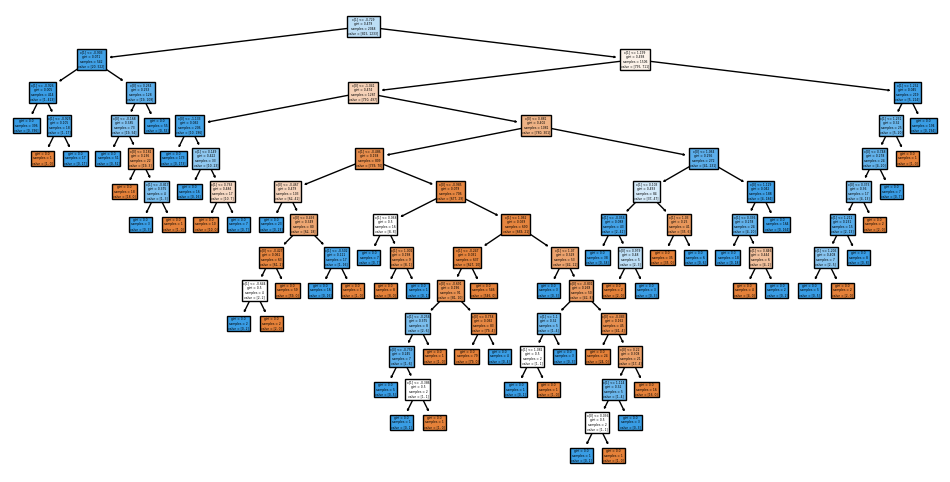

In [33]:
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, filled=True, feature_names=None, class_names=None)
plt.show()

In [41]:
#Decision Tree for D_512
clf = DecisionTreeClassifier(random_state=27)
clf.fit(X_train_512,y_train_512)

num_nodes = clf.tree_.node_count
print(f"Number of nodes: {num_nodes}")

Number of nodes: 59


In [19]:
y_pred = clf.predict(X_test)

err_512 = 1-accuracy_score(y_test, y_pred)
print("Error:", err_512)

Error: 0.042035398230088505


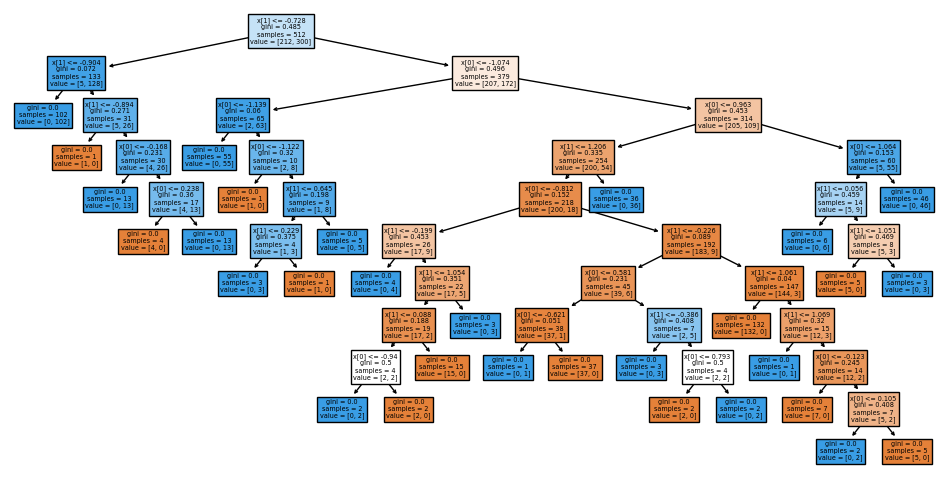

In [35]:
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, filled=True, feature_names=None, class_names=None)
plt.show()

In [40]:
#Decision Tree for D_128
clf = DecisionTreeClassifier(random_state=27)
clf.fit(X_train_128,y_train_128)

num_nodes = clf.tree_.node_count
print(f"Number of nodes: {num_nodes}")

Number of nodes: 23


In [21]:
y_pred = clf.predict(X_test)

err_128 = 1-accuracy_score(y_test, y_pred)
print("Error:", err_128)

Error: 0.08241150442477874


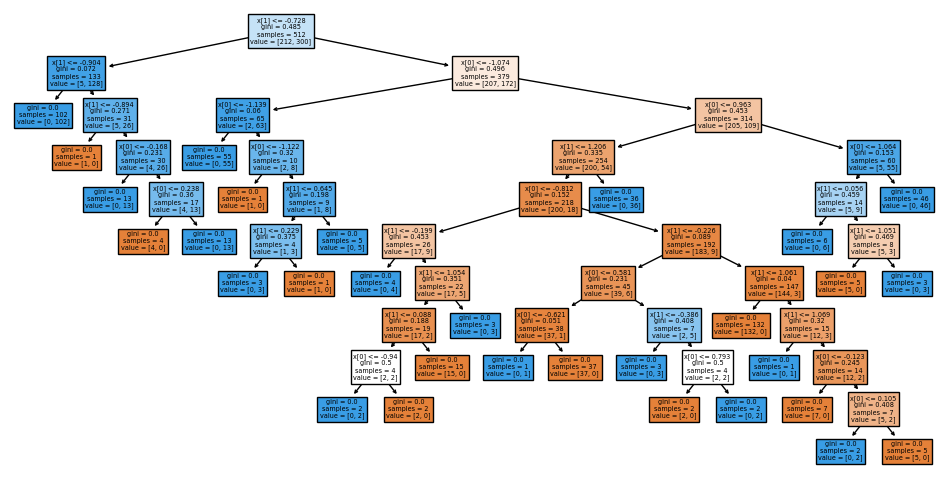

In [36]:
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, filled=True, feature_names=None, class_names=None)
plt.show()

In [39]:
#Decision Tree for D_32
clf = DecisionTreeClassifier(random_state=27)
clf.fit(X_train_32,y_train_32)

num_nodes = clf.tree_.node_count
print(f"Number of nodes: {num_nodes}")

Number of nodes: 13


In [23]:
y_pred = clf.predict(X_test)

err_32 = 1-accuracy_score(y_test, y_pred)
print("Error:", err_32)

Error: 0.18639380530973448


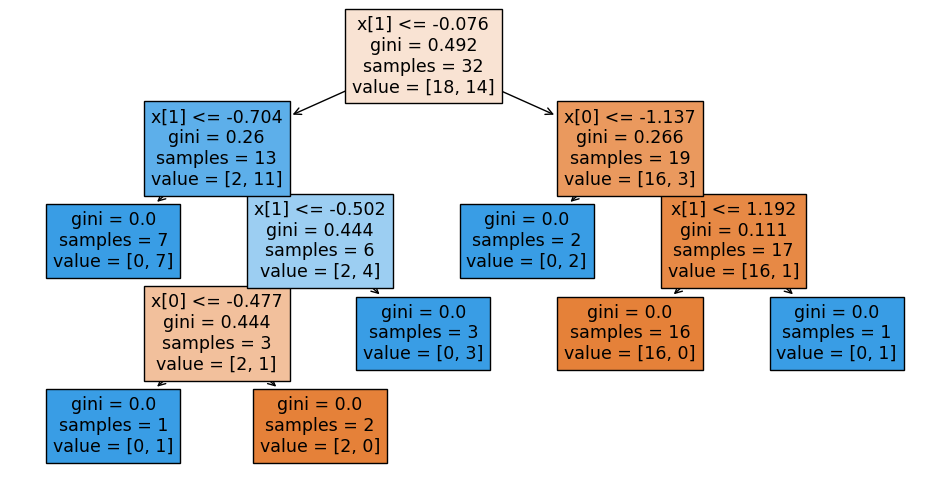

In [38]:
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, filled=True, feature_names=None, class_names=None)
plt.show()

Section 4 - Lagrange Interpolation

In [1]:
from scipy.interpolate import lagrange
from scipy.stats import uniform, norm, lognorm
from sklearn.metrics import mean_squared_error

Train Log Mean Squared Error: 341.9419
Test Log Mean Squared Error: 342.4628


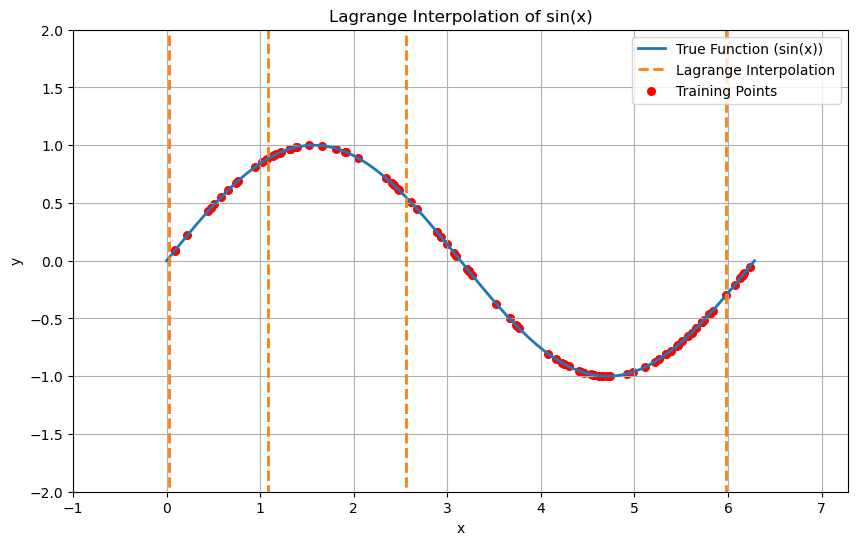

In [12]:
# Define the interval [a, b] and the number of sample points
a, b, n = 0, 2*np.pi, 100

# Sample n points uniformly from the interval [a, b]
np.random.seed(27)
x_train = np.random.uniform(a, b, n)
y_train = np.sin(x_train)

# Define the Lagrange interpolation function
def lg_interp(x_train, y_train, x):
    interp_func = lagrange(x_train, y_train)
    return interp_func(x)

# Generate a test set using the same distribution
x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

# Compute the log mean squared error for the training and test sets
log_mse_train = np.log(np.mean((lg_interp(x_train, y_train, x_train) - y_train)**2))
log_mse_test = np.log(np.mean((lg_interp(x_train, y_train, x_test) - y_test)**2))

# Print the results
print(f"Train Log Mean Squared Error: {log_mse_train:.4f}")
print(f"Test Log Mean Squared Error: {log_mse_test:.4f}")

# Plot the original function and the Lagrange interpolation
x_plot = np.linspace(a, b, 1000)
y_plot_true = np.sin(x_plot)
y_plot_interp = lg_interp(x_train, y_train, x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_plot_true, label='True Function (sin(x))', linewidth=2)
plt.plot(x_plot, y_plot_interp, label='Lagrange Interpolation', linestyle='dashed', linewidth=2)
plt.scatter(x_train, y_train, label='Training Points', color='red', s=30)
plt.legend()
plt.title('Lagrange Interpolation of sin(x)')
plt.xlabel('x')
plt.xlim(-1, 2*np.pi+1)
plt.ylabel('y')
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

Observation:

When looking at the true function, along with the randomized training points along it, and comparing it to the Lagrange Interpolation, it should be observed that the Lagrange interpolation completly overfitted the data from the visual. Looking at the Log MSE it can also be seen that the error is astronomically high at ~345-350 which shows the degree to which the Lagrange Interpolation is overfitting the model. Since the sample size is n=100 the Lagrange Interpolation is of degree 99 which enables it to overfit the model significantly. If the sample size was n=10 the Lagrange Interpolation would have a much easier time fitting to the true function than it is here with degree 99.

What can be observed in the code below is that with Standard deviation and noise incorporated into the model the preformance of the model on the test set becomes significantly better than it was in the plot above. The Log MSE goes to 0 by the time that it hits a standard deviation of 25, showing it as an almost perfect lagrange interpolation by that point.

Experiment 1: Epsilon Standard Deviation = 1
Train Log MSE: 347.8856444844999
Test Log MSE: 316.95718526514423

Experiment 2: Epsilon Standard Deviation = 5
Train Log MSE: 284.5921496271744
Test Log MSE: 144.3009684360268

Experiment 3: Epsilon Standard Deviation = 10
Train Log MSE: 300.0397688255183
Test Log MSE: 70.7782504143594

Experiment 4: Epsilon Standard Deviation = 15
Train Log MSE: 241.40473457294308
Test Log MSE: -0.6359319977029774

Experiment 5: Epsilon Standard Deviation = 20
Train Log MSE: 248.31031496562122
Test Log MSE: -18.621477131906865

Experiment 6: Epsilon Standard Deviation = 25
Train Log MSE: 315.53003268174524
Test Log MSE: 0.5398443535984205

Experiment 7: Epsilon Standard Deviation = 30
Train Log MSE: 285.1540924220126
Test Log MSE: -24.93188931799421



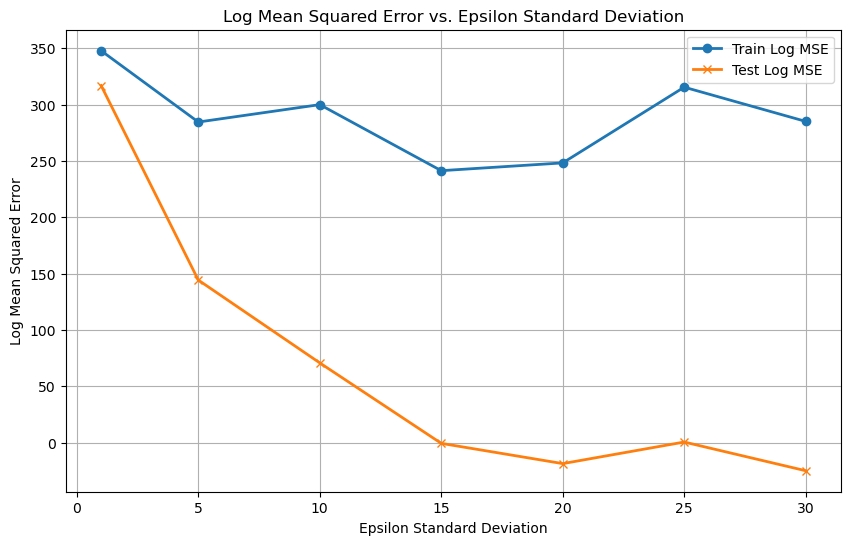

In [13]:
epsilon_std_devs = [1, 5, 10, 15, 20, 25, 30]  # Standard deviations for epsilon

# Function to calculate log mean squared error
def log_mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.log(mse)

# Generate the training set
x_train = np.linspace(a, b, n)
y_train = np.sin(x_train)

# Initialize lists to store results
train_log_mse_results = []
test_log_mse_results = []

# Perform experiments
for epsilon_std_dev in epsilon_std_devs:
    # Generate the noisy training set
    epsilon = np.random.normal(0, epsilon_std_dev, n)
    x_noisy_train = x_train + epsilon
    y_noisy_train = np.sin(x_noisy_train)

    # Build the Lagrange interpolation model
    lagrange_interpolation = lagrange(x_noisy_train, y_noisy_train)

    # Generate the test set (same as training set)
    x_test = np.linspace(a, b, n)
    y_test = np.sin(x_test)

    # Evaluate the model on training and test data
    y_train_pred = lagrange_interpolation(x_noisy_train)
    y_test_pred = lagrange_interpolation(x_test)

    # Compute log mean squared error for training and test sets
    train_log_mse = log_mse(y_noisy_train, y_train_pred)
    test_log_mse = log_mse(y_test, y_test_pred)

    train_log_mse_results.append(train_log_mse)
    test_log_mse_results.append(test_log_mse)

# Print the results
for i, epsilon_std_dev in enumerate(epsilon_std_devs):
    print(f"Experiment {i+1}: Epsilon Standard Deviation = {epsilon_std_dev}")
    print(f"Train Log MSE: {train_log_mse_results[i]}")
    print(f"Test Log MSE: {test_log_mse_results[i]}\n")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_std_devs, train_log_mse_results, marker='o', label='Train Log MSE', linewidth=2)
plt.plot(epsilon_std_devs, test_log_mse_results, marker='x', label='Test Log MSE', linewidth=2)
plt.title('Log Mean Squared Error vs. Epsilon Standard Deviation')
plt.xlabel('Epsilon Standard Deviation')
plt.ylabel('Log Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()